In [28]:
# Libraries for data manipulation
import pandas as pd 
import numpy as np
# Libraries for test-train split & deploying isolation forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
# Libraries for viz
import matplotlib.pyplot as plt
import seaborn as sns
# Libraries for autoencoder
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from keras.optimizers import Adam
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

We will deploy and try to understand the methods while eventually comparing results of different chosen approaches. We will be using GPT 4 for guidance to choose and apply the different approaches given our problem statement. 
**Our objective will be to maximise the recall value with a high precision value.**

# 1. Data Pre-processing

In [29]:
# Reading in the data
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [30]:
# A glance at the data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [31]:
# A look at the predictor variable
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

## 1.1 Removing Duplicate Values

In [32]:
# Removing duplicate values 
data.drop_duplicates(subset = None, keep = "first", inplace = True, ignore_index = True)

In [33]:
# Again having a look at the shape of the data to check the number of removed rows
dedup_rows = len(data)
data.shape

(283726, 31)

In [34]:
# Total rows removed 
print("Total duplicate rows removed : ", original_rows -dedup_rows)

Total duplicate rows removed :  1081


In [35]:
# A look at the predictor variable
data["Class"].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

## 1.2 Variable Correlation

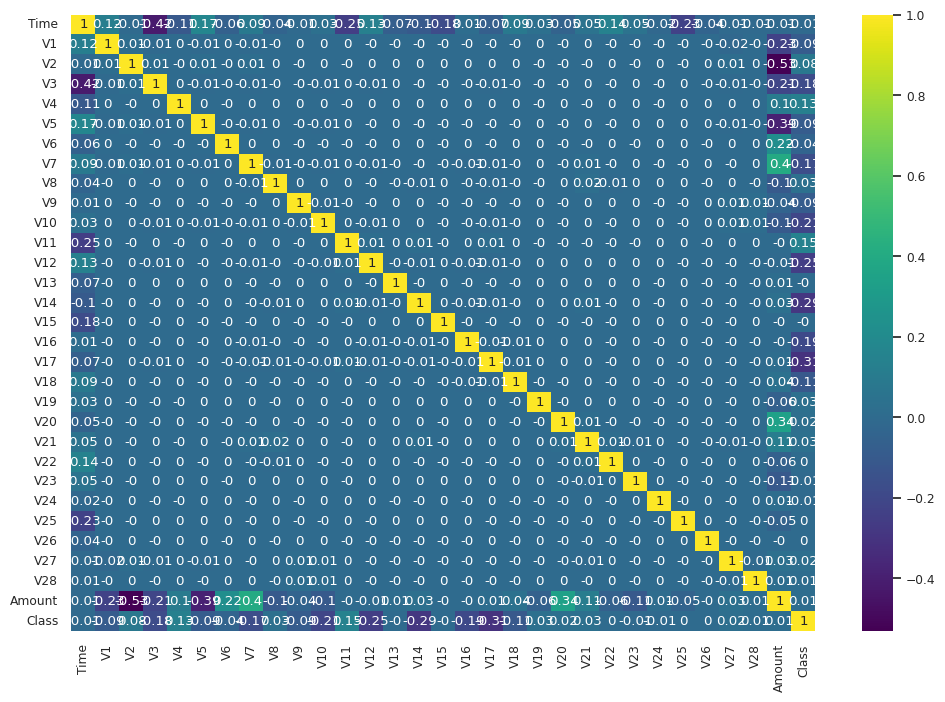

In [36]:
# Looking at the variable correlations
corr= round(data.corr(),2)
plt.figure(figsize=(12,8))
sns.set(font_scale=0.8)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

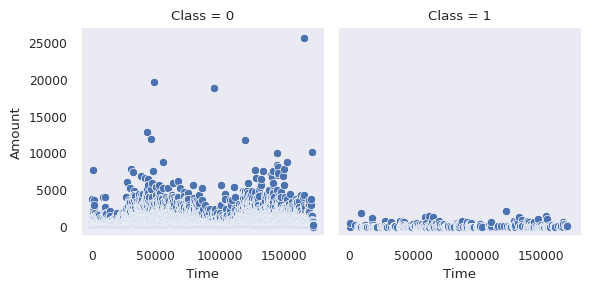

In [37]:
# Visually inspecting the impact of Amount over frauds
sns.set_style(style='dark')
sns.FacetGrid(data=data, col='Class').map(sns.scatterplot, 'Time', 'Amount', palette='muted')

# 2. Isolation Trees

Isolation Trees (iTrees) are a type of algorithm primarily used for anomaly detection. They work by isolating observations, assuming that anomalies are easier to isolate compared to normal points due to their fewer numbers and distinct attribute values. An iTree recursively partitions the data by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. This process continues until the points are isolated or a limit in tree depth is reached. Anomalies tend to have shorter paths in the tree, indicating they are easier to isolate.

![](http://https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fcf1c1d99-47bb-4a34-aec5-3431a929335f%2FUntitled.png?table=block&id=79c1ba86-2c87-4f38-8c7f-c496f1763aaf&cache=v2)

This is a highly imbalanced dataset and it makes perfect sense to apply Isolation trees as :
1. the algorithm focusses on isolating anomalies
2. they work well with high dimension data and don't suffer from the curse of dimensionality
3. they use random features to work with which makes them highly scalable and efficient in terms of required computational power

In [38]:
tree = [10, 25, 50, 100, 150, 200, 250, 500,1000]
for value in tree :
    iso_forest = IsolationForest(n_estimators=value, contamination='auto', random_state=42)
    iso_forest.fit(X_train)
    test_predictions = iso_forest.predict(X_test)
    test_binary_predictions = np.where(test_predictions == -1, 1, 0)
    print("No of trees used for prediction ",value, "\n", confusion_matrix(y_test, test_binary_predictions), "\n", classification_report(y_test, test_binary_predictions))

No of trees used for prediction  10 
 [[54621  2030]
 [   26    69]] 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56651
           1       0.03      0.73      0.06        95

    accuracy                           0.96     56746
   macro avg       0.52      0.85      0.52     56746
weighted avg       1.00      0.96      0.98     56746

No of trees used for prediction  25 
 [[55026  1625]
 [   22    73]] 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.04      0.77      0.08        95

    accuracy                           0.97     56746
   macro avg       0.52      0.87      0.53     56746
weighted avg       1.00      0.97      0.98     56746

No of trees used for prediction  50 
 [[55157  1494]
 [   19    76]] 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05 

# 3. Autoencoders

Autoencoders are trained to compress (encode) the input data into a lower-dimensional representation and then reconstruct (decode) it back to the original input. By training exclusively on normal (non-fraudulent) transactions, the autoencoder learns to capture the typical patterns of normal behavior.

When a new transaction is input into the trained autoencoder, if the transaction is normal, the autoencoder should be able to reconstruct it well, resulting in a low reconstruction error. However, if the transaction is fraudulent (thus differing from the normal pattern it has learned), the reconstruction error will be high, signaling a potential anomaly.

## 3.1 Data Creation for Auto Encoders

In [47]:
# Reset index to make index a column
X_train_reset = X_train.reset_index()
y_train_reset = y_train.reset_index()

# Now merge using 'index' as a column
merged_df = X_train_reset.merge(y_train_reset, on='index', how='left')

# Creatig copy of merged_df
X_train_normal = merged_df.copy()

# Selecting only non-fraudulent transactions
X_train_normal = X_train_normal[X_train_normal["Class"] == 0]

# Dropping the column Class 
X_train_normal = X_train_normal.drop(columns = ["Class", "index"])

In [40]:
X_train_normal.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,...,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000,226602.000000
mean,0.012789,-0.011443,0.013758,-0.009532,0.010047,0.000457,0.010351,-0.001889,0.001394,0.007097,...,-0.000453,-0.000043,0.000266,-0.000085,-0.000126,0.000231,0.000149,0.000206,0.001323,0.000802
std,1.919779,1.635972,1.452676,1.401044,1.337444,1.321399,1.146774,1.145252,1.085282,1.032106,...,0.811436,0.758108,0.713231,0.723275,0.623698,0.605941,0.521027,0.481400,0.387330,0.325254
min,-56.407510,-72.715728,-33.680984,-5.683171,-32.092129,-26.160506,-31.764946,-73.216718,-6.290730,-14.741096,...,-7.213527,-23.646890,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896
25%,-0.913139,-0.602321,-0.881977,-0.850583,-0.687312,-0.767186,-0.550030,-0.208658,-0.641668,-0.533578,...,-0.455445,-0.211599,-0.228200,-0.541649,-0.162227,-0.354649,-0.317707,-0.326644,-0.070535,-0.052620
50%,0.020267,0.062241,0.180605,-0.024342,-0.051727,-0.274825,0.041683,0.021878,-0.052277,-0.092643,...,0.004334,-0.062367,-0.029025,0.007330,-0.011334,0.041258,0.016051,-0.051820,0.001411,0.011401
75%,1.315818,0.798021,1.028578,0.736022,0.615650,0.398265,0.572570,0.324295,0.595244,0.455387,...,0.458417,0.132865,0.186185,0.528637,0.148022,0.440410,0.351057,0.239838,0.090966,0.078468
max,2.454930,18.902453,9.382558,16.875344,34.801666,21.393069,34.303177,18.709255,15.594995,23.745136,...,5.572113,39.420904,22.614889,10.503090,22.528412,4.016342,7.519589,3.517346,12.152401,33.847808


We can observe that the variables have values between -100 to 100 and hence before making any decision we would like to see the distribution of the variables

## 3.2 Variable Distribution

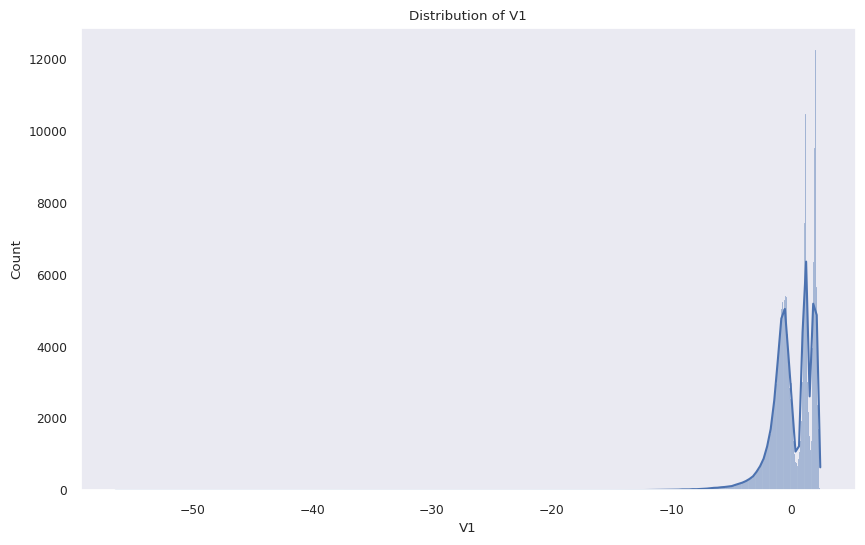

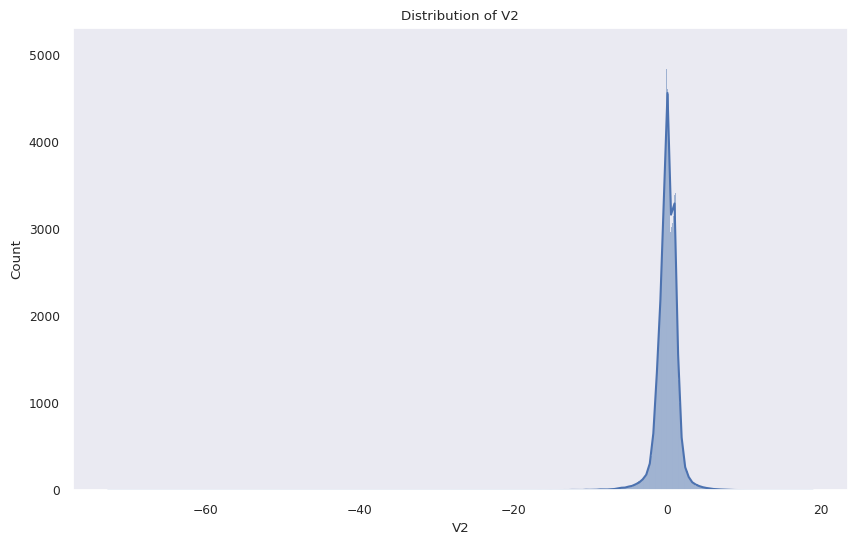

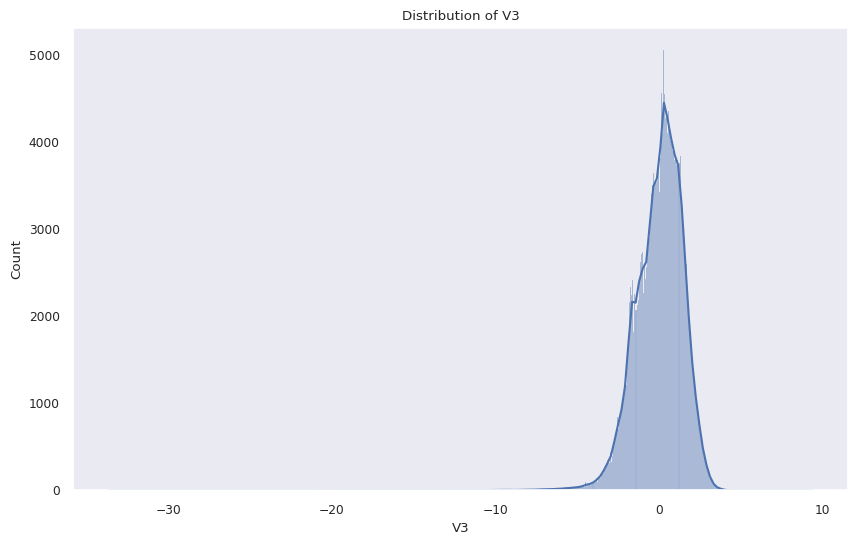

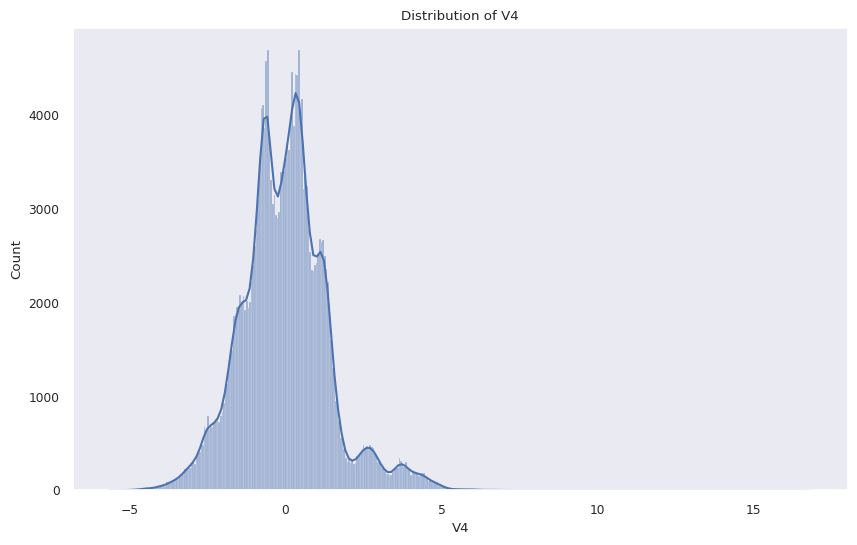

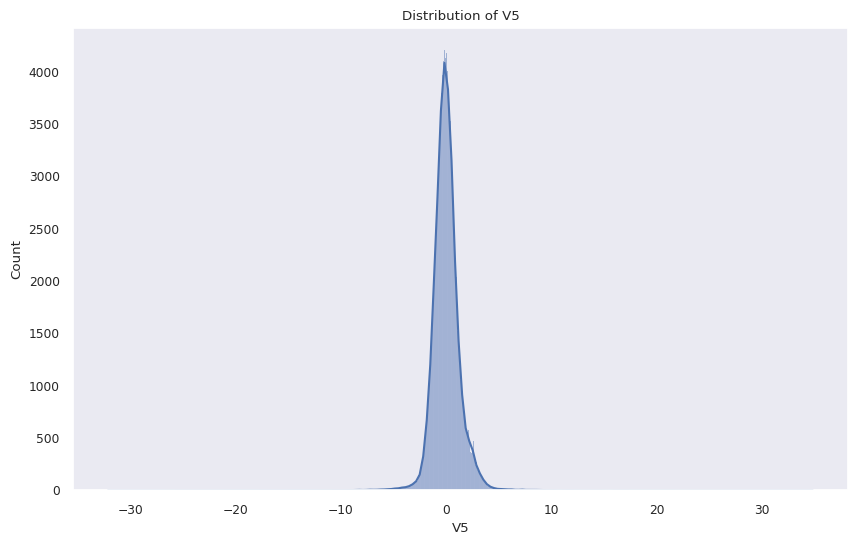

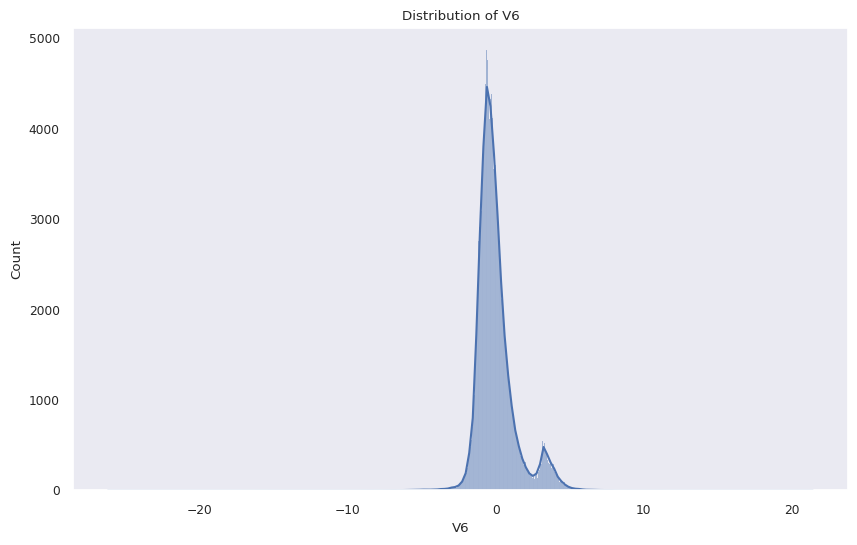

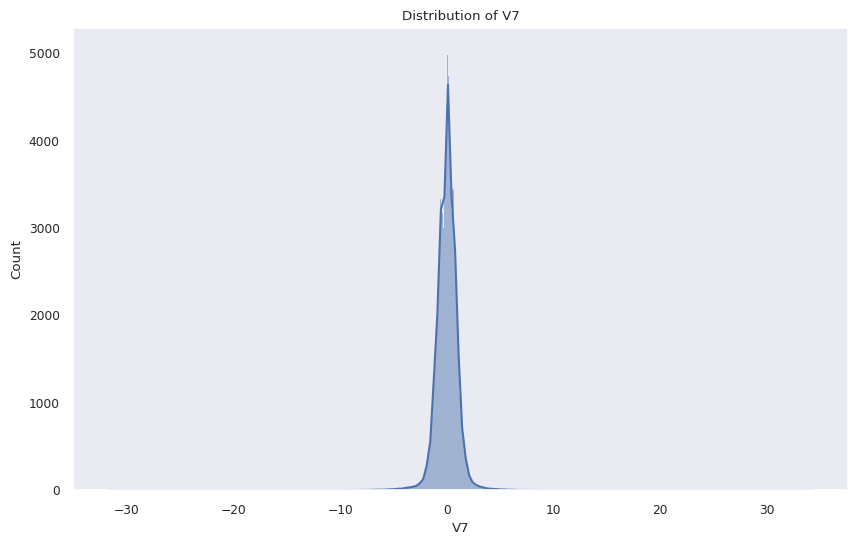

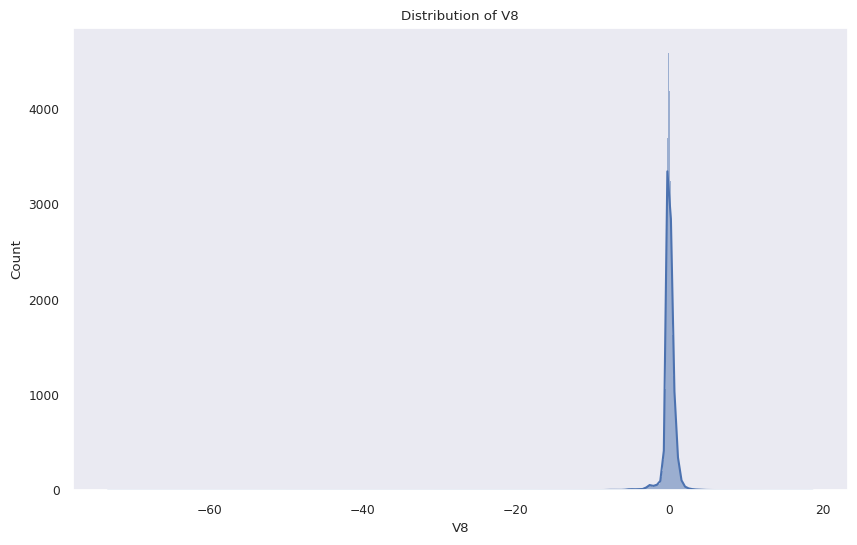

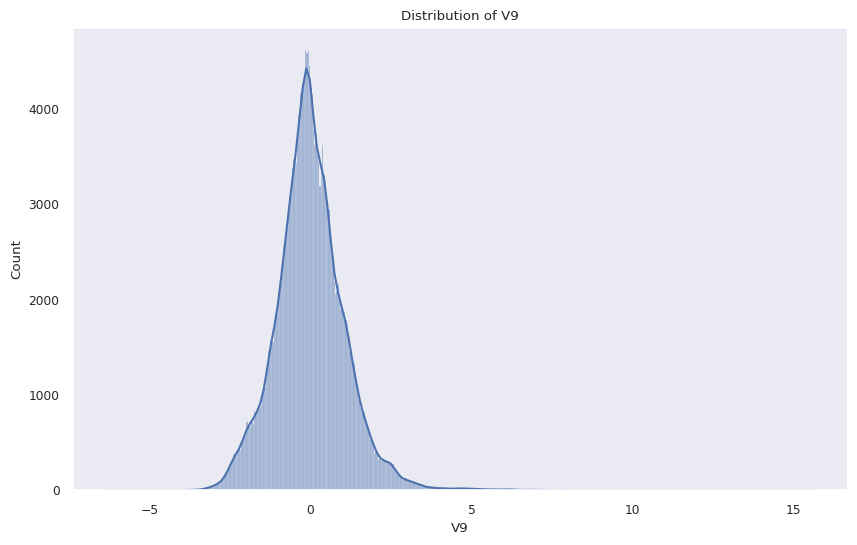

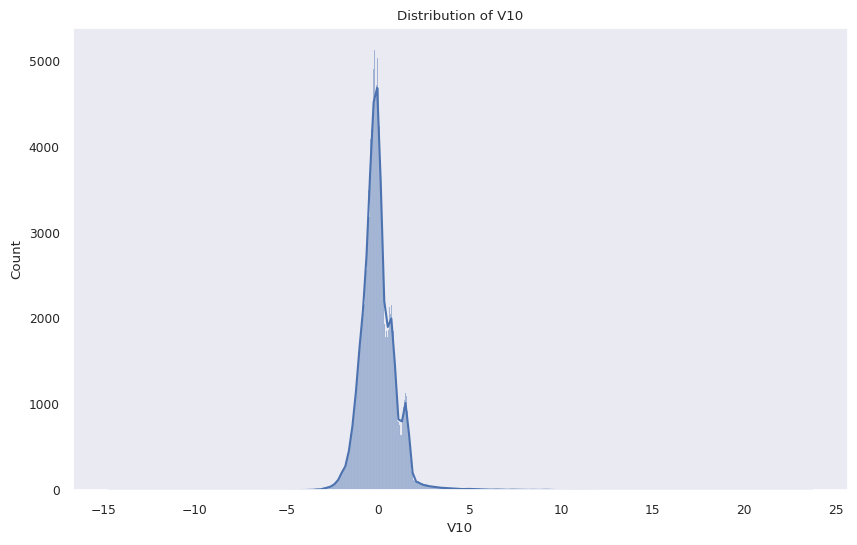

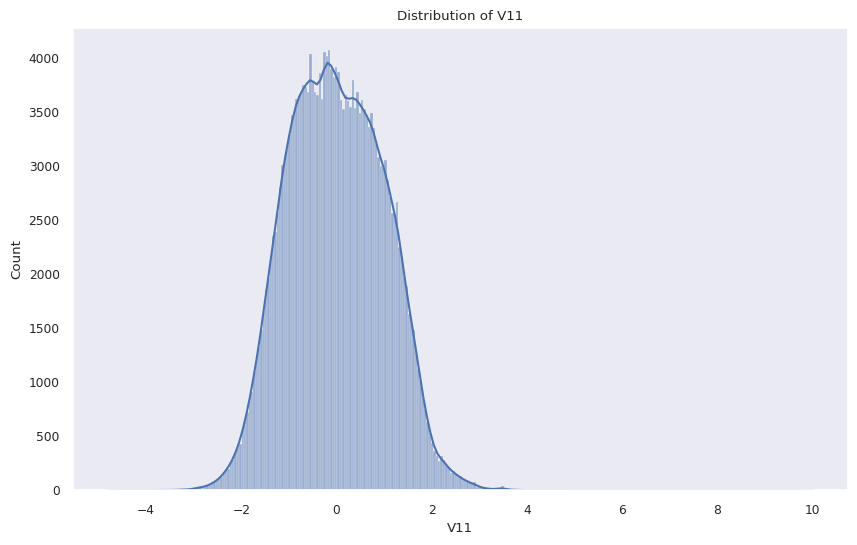

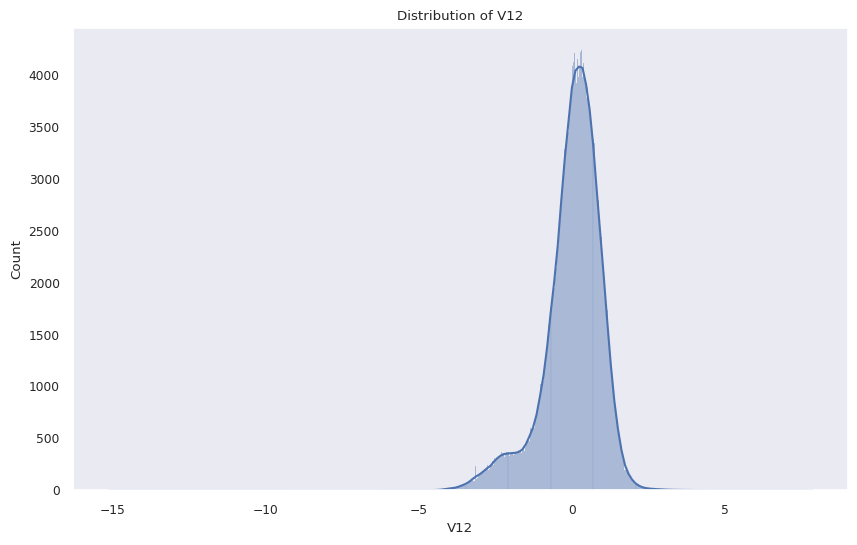

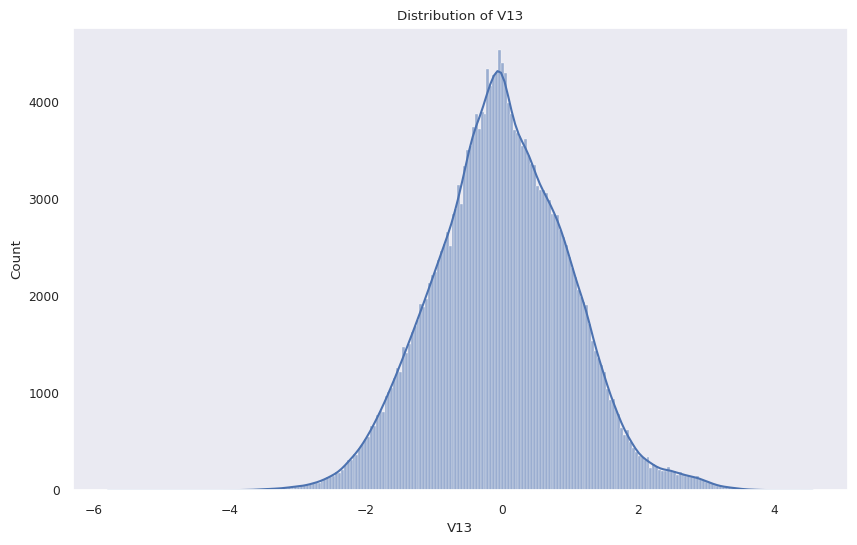

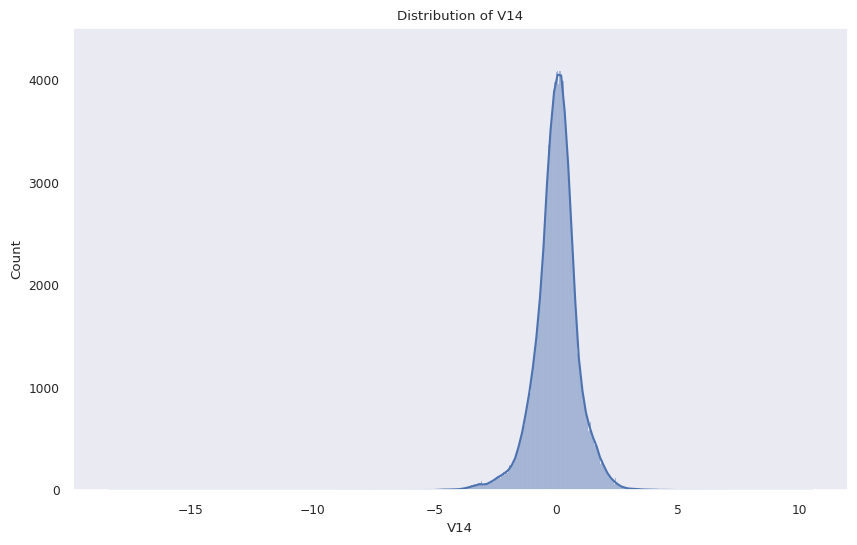

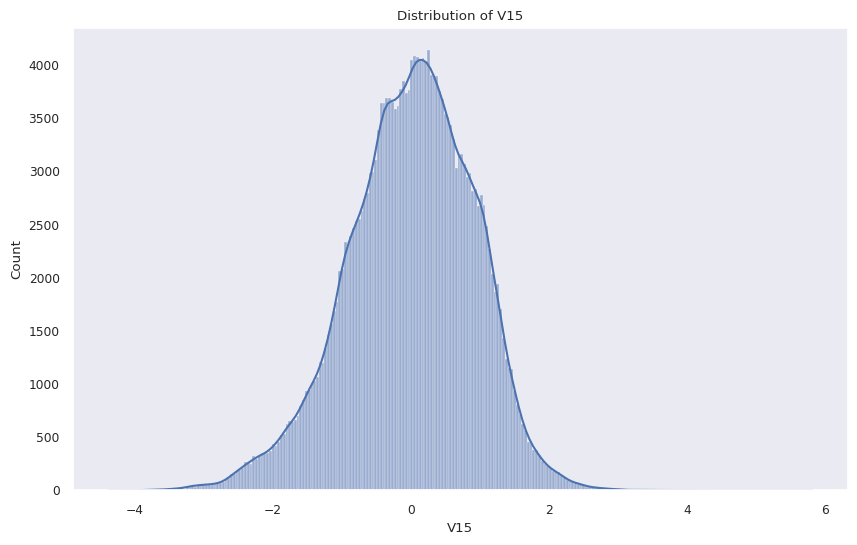

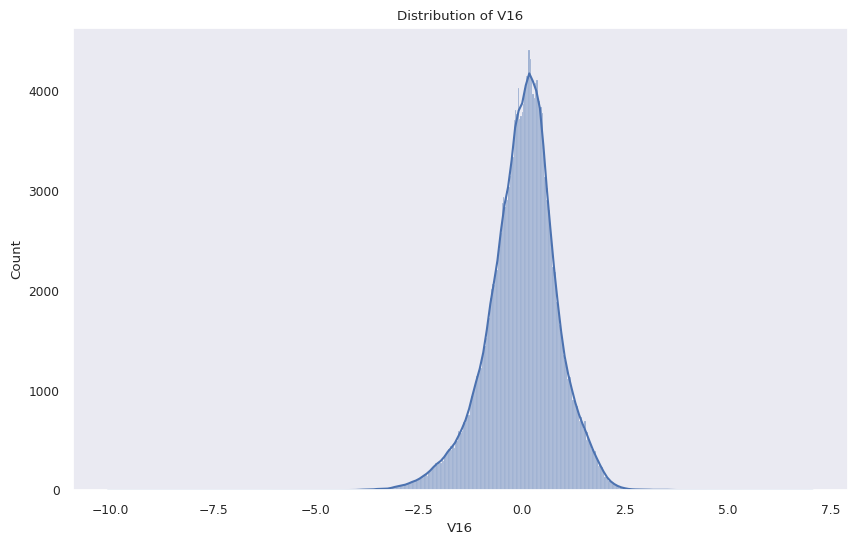

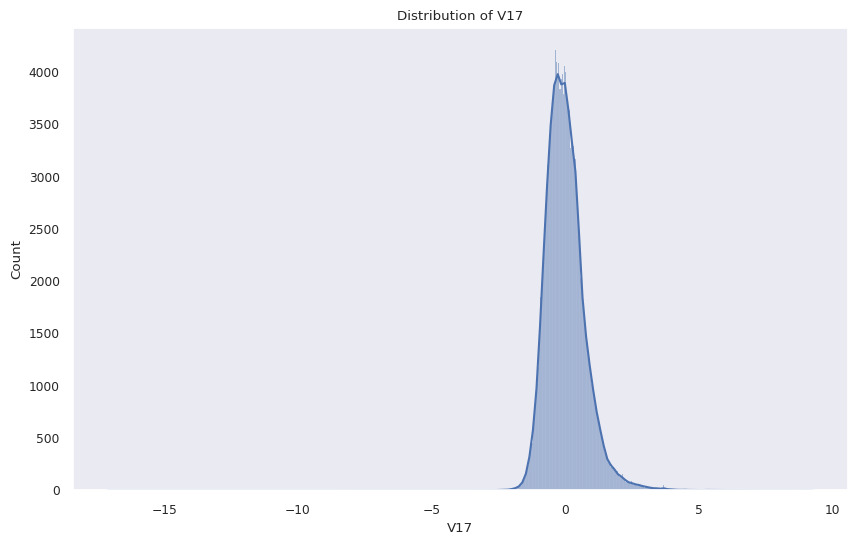

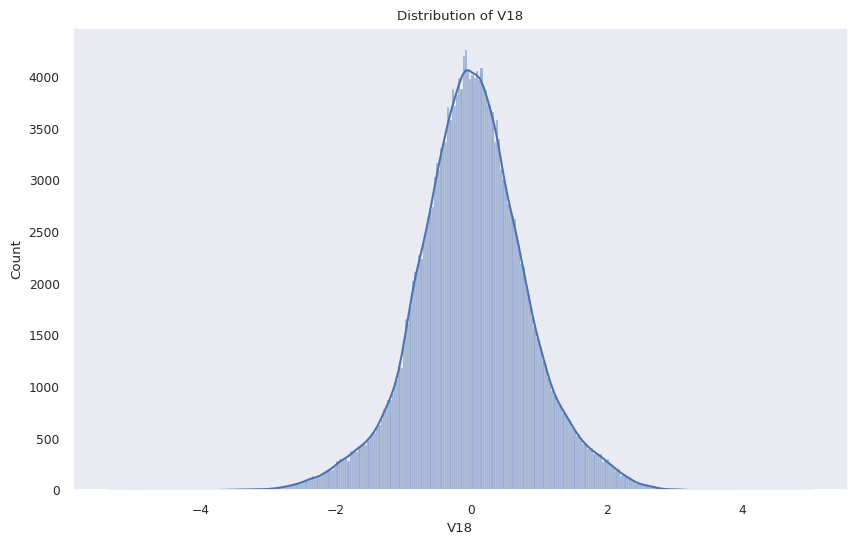

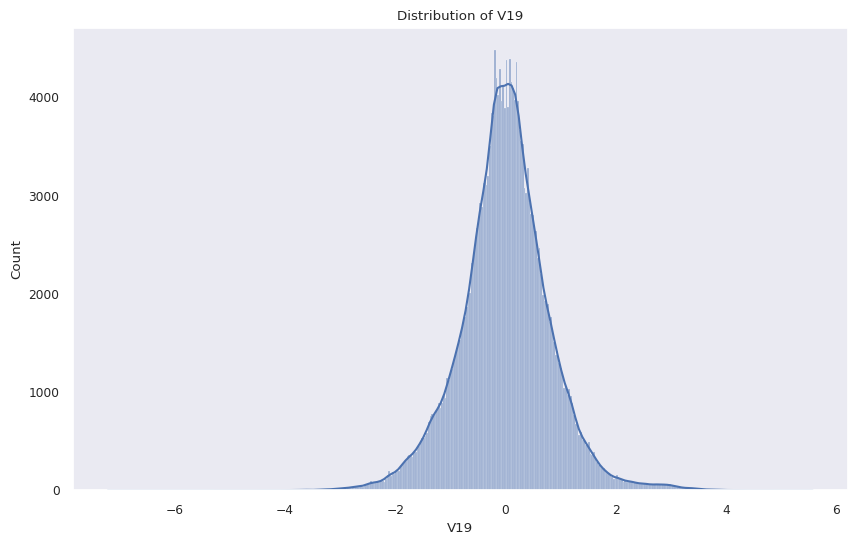

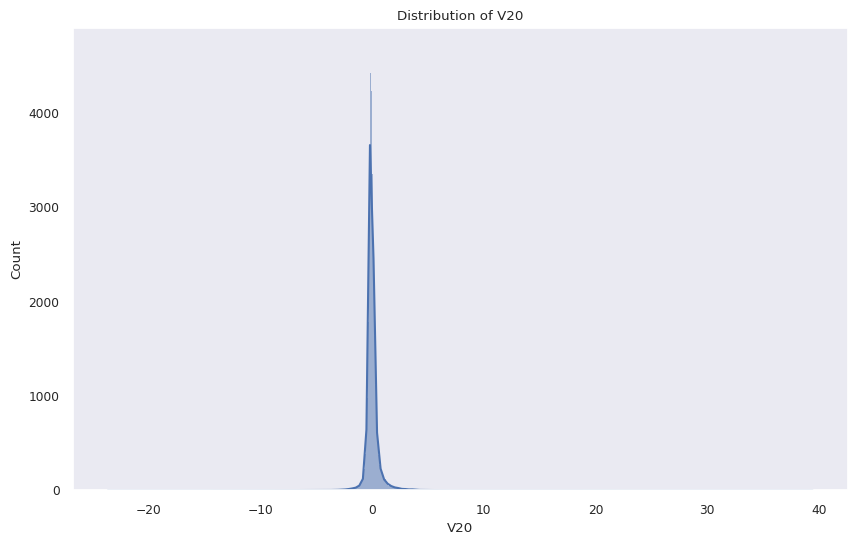

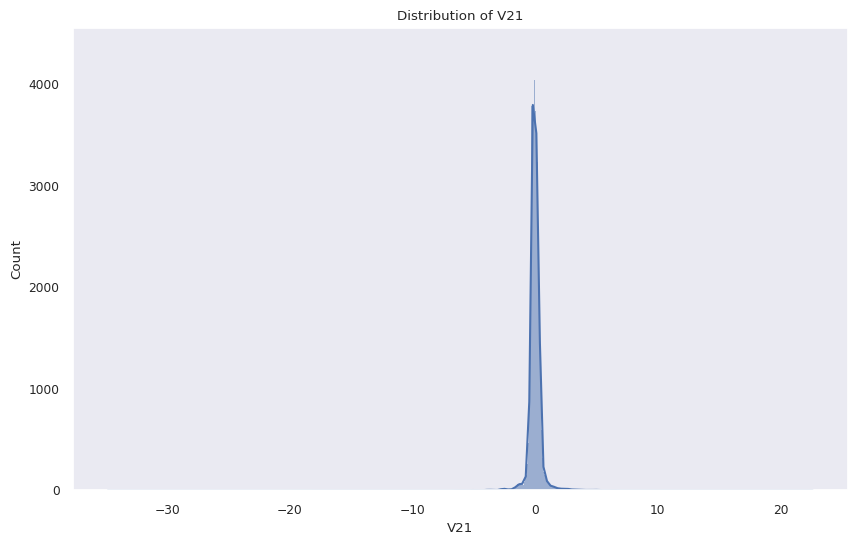

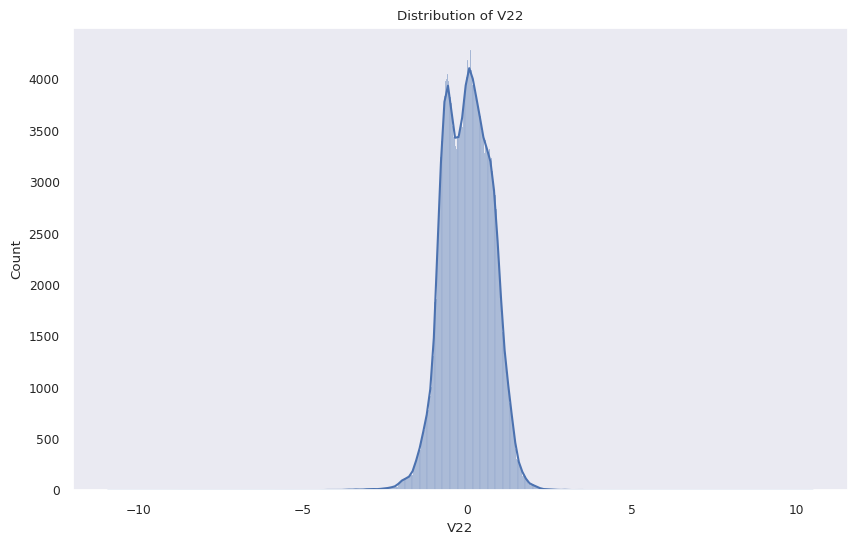

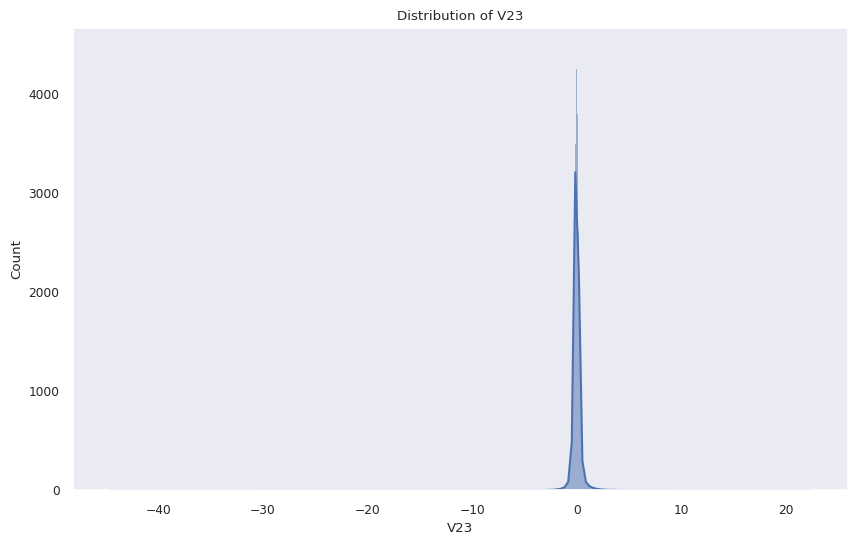

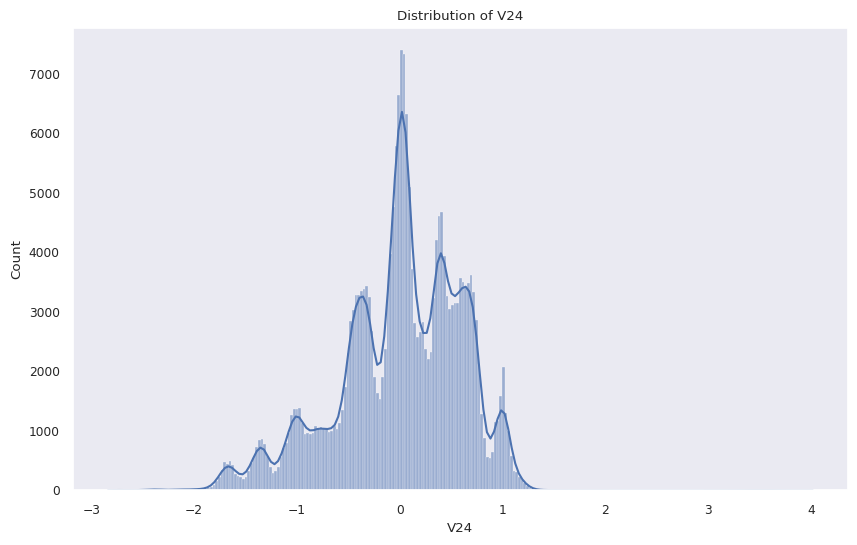

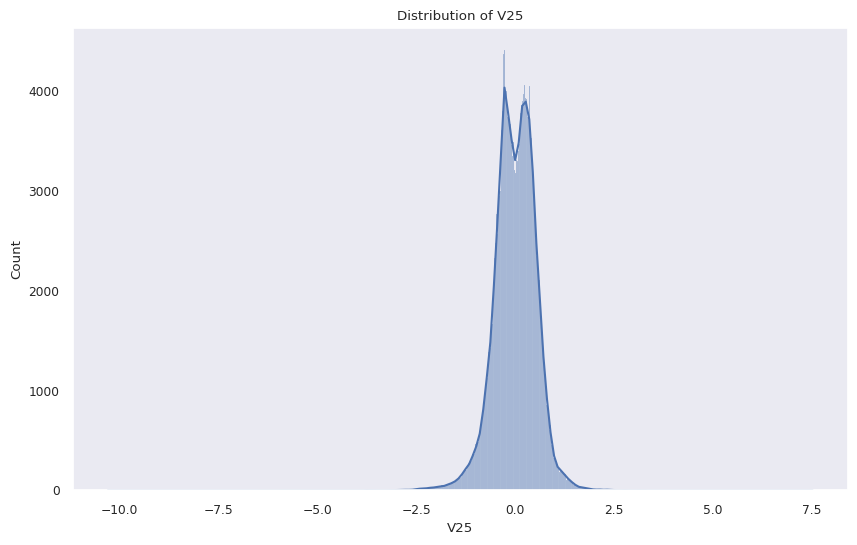

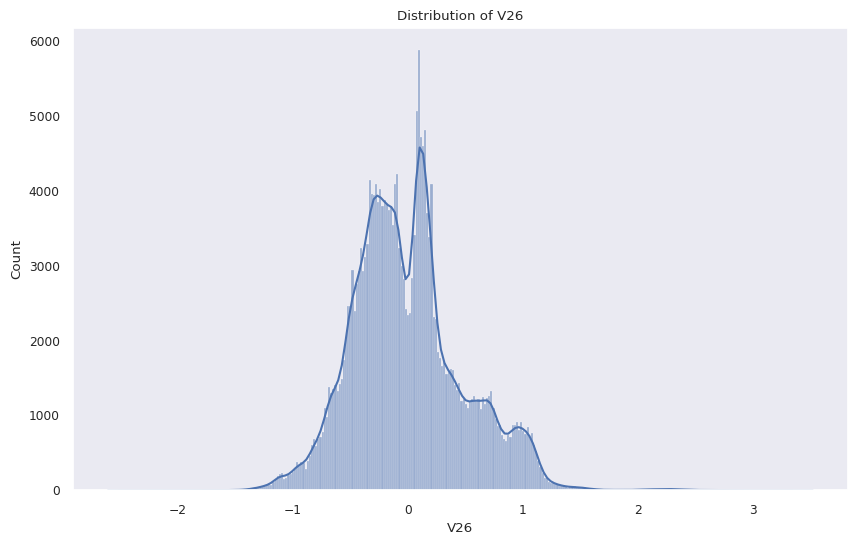

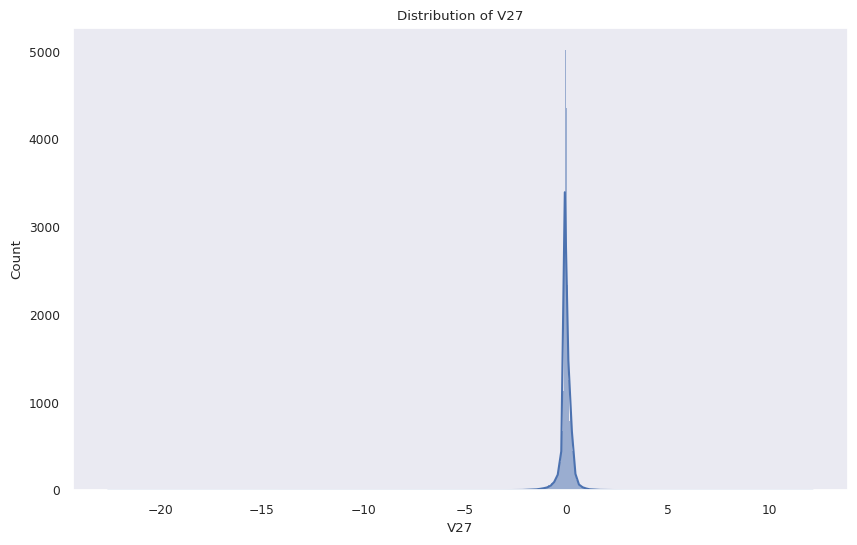

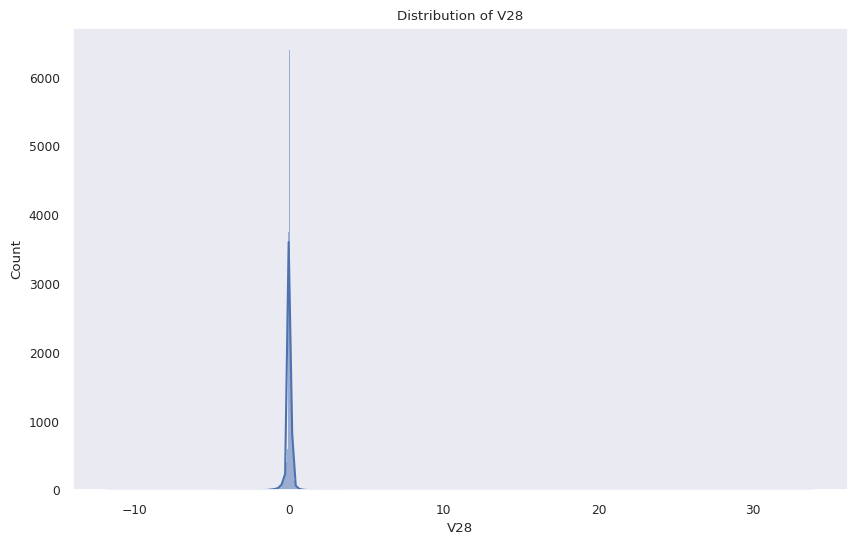

In [41]:
for col in X_train_normal.columns:
    plt.figure(figsize=(10, 6))  # Specify your desired figure size
    sns.histplot(data=X_train_normal[col], kde=True)
    plt.title(f'Distribution of {col}')  # Optional: Adds a title to each plot
    plt.show()

We observe that all variables are normally distributed hence we can go ahead with z-scale normalisation

## 3.3 Variable Scaling

In [42]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_train_normal_scaled = scaler.fit_transform(X_train_normal)

# Convert the scaled data back to a DataFrame (optional, for convenience)
X_train_normal_scaled = pd.DataFrame(X_train_normal_scaled, columns=X_train_normal.columns)

## 3.4 Algorithm Application

In [43]:
learning_rates = [0.05, 0.1, 0.15]  # Define learning rates to test
threshold_percentiles = [79, 82, 85]  # Define percentile values for setting thresholds

# Initialize the StandardScaler
scaler = StandardScaler()
# Assuming X_test is your test dataset
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

for lr in learning_rates:
    # Define the architecture
    input_dim = X_train_normal_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Compile the autoencoder with the current learning rate
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    # Train the autoencoder
    autoencoder.fit(X_train_normal_scaled, X_train_normal_scaled,
                    epochs=50,
                    batch_size=1024,
                    shuffle=True,
                    validation_split=0.2)

    # Predict on the test set
    reconstructed = autoencoder.predict(X_test_scaled)

    # Calculate MSE for each instance
    mse = np.mean(np.square(X_test_scaled - reconstructed), axis=1)

    for percentile in threshold_percentiles:
        # Determine a threshold for anomaly detection
        threshold = np.percentile(mse, percentile)  # Set threshold based on the defined percentile of MSE

        # Detect anomalies
        anomalies = mse > threshold

        # Evaluate the model
        print(f"Results for learning rate: {lr} and threshold percentile: {percentile}")
        print(confusion_matrix(y_test, anomalies))
        print(classification_report(y_test, anomalies))

Epoch 1/50
178/178 [==============================] - 2s 7ms/step - loss: 0.9973 - val_loss: 1.0164
Epoch 2/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 3/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 4/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 5/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 6/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 7/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 8/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 9/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164
Epoch 10/50
178/178 [==============================] - 1s 6ms/step - loss: 0.9959 - val_loss: 1.0164

We can see that there is a massive improvement using an autoencoder with the recall value hitting as high as 89% but there is significant compute that takes place to come to this result and the precision has also dropped significantly. 

This notebook is a WIP and we will use more techniques to find the best technique for fraud detection.

To be continued !

Upon analyzing we observe that we get the **best results with 50 trees where we get a recall value of 80% and precision of around 5%**

Going forward we would like to improve upon the recall value first of all and then focus on the precision value